In [1]:
import pandas as pd
from math import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
import time
import random

# LAB 2 - PART I.1 and I.2

**What is the lower bound  for the number of training examples N?**

We need N>n (n is dimension of the output representation = number of weights): the lower bound is n.


**What happens with the error if N = n? Why?**


There is only one solution to the system (4): the training error will converge to 0 if the system has a solution, else the error won't converge?


**Under what conditions, if any, does (4) have a solution in this case?**

If we represent this system as $\Phi W = f$ then we need $\Phi$ to be invertible for the system to have ONE solution or we need the rank of $\Phi$ to be the same as the rank of the concatenation of $\Phi$ and $f$ for the system to have at least one solution.

**During training we use an error measure defi􏰀ned over the training examples. Is it good to use this measure when evaluating the performance of the network? Explain!**

Using the same error (MSE) but for the test samples is fine?

## 3.1 Batch mode training using least squares - supervised learning of network weights

### Creating the patterns (train and testdatasets)

In [2]:
pattern_test = np.arange(0, 2*np.pi, 0.1)
pattern_train = np.arange(0.05, 2*np.pi, 0.1)

sin_test = np.sin(2*pattern_test)
sin_train = np.sin(2*pattern_train)


In [3]:
def box(x):
    if x >= 0 : 
        return 1
    else :
        return -1

vbox = np.vectorize(box)
square_test = vbox(sin_test)
square_train = vbox(sin_train)

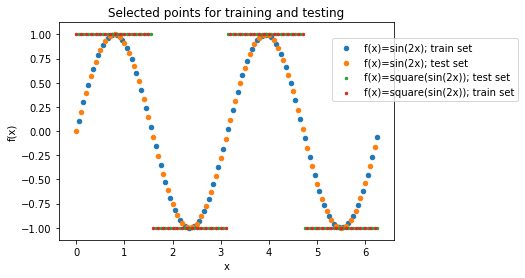

In [4]:
plt.scatter( pattern_train, sin_train, s=20, label ="f(x)=sin(2x); train set")
plt.scatter(pattern_test, sin_test, s=20, label ="f(x)=sin(2x); test set")
plt.scatter(pattern_train, square_train, s=6, label ="f(x)=square(sin(2x)); test set")
plt.scatter(pattern_test, square_test, s=6, label ="f(x)=square(sin(2x)); train set")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend(bbox_to_anchor=(0.8, 0.95))
plt.title("Selected points for training and testing")
plt.savefig("I1_test_train_data.png")
plt.show()

### Implementing batch learning (all samples accessible at once)

We decide to place the RBFs equidistancely inside the input domain, leaving have that distance before the first RBF and after the last RBF.

We choose sigma so that centers don't overlap too much (we don't want the centers to be too spread out)

In [5]:
def placeRBFs(n, pattern_0, pattern_f) :
    """
    Places the RBFs equidistancely inside the input domain (1D case here)
    leaving half that distance before the first RBF and after the last RBF
    
    inputs:
    number of RBFs
    pattern_0: lower boundary of input interval
    pattern_f: upper boundary of output interval
    
    output:
    RBF positions in R
    
    """
    d = (pattern_f - pattern_0)*1.0/n
    return np.arange(pattern_0 + d/2, pattern_f - d/2 + 10**-8, d)

def gaussianRBF(x, i, mu, sigma):
    return np.exp(-(x-mu[i])**2/(2*(sigma[i]**2)))
    #return np.exp(-(x-mu[i])**2/(2*(sigma[i]**2)))

def transpose(M) :
    return [[M[i][j] for i in range(len(M))] for j in range(len(M[0]))]


def trainRBF(n_RBF, x_train, y_train, x_test, y_test, var_RBF = 1, apply_box_pred=False) :
    
    # computing phi matrix
    mu = placeRBFs(n_RBF, 0, 2*np.pi)
    #var_RBF = 2*np.pi/n_RBF*k_var
    sigma = var_RBF * np.ones(n_RBF)
    phi_i = gaussianRBF(0.1, 2, mu, sigma)
    phi = np.array([[gaussianRBF(x_train[j], i, mu, sigma) for i in range(n_RBF)]
                    for j in range(len(x_train))])
    phiT = np.array(transpose(phi))
    
    # solving least squares
    w = np.linalg.inv(phiT.dot(phi)).dot(phiT.dot(y_train))
    
    #
    phi_test = np.array([[gaussianRBF(x_test[j], i, mu, sigma) for i in range(n_RBF)] for j in range(len(x_train))])
    y_pred = phi_test.dot(w)
    
    if apply_box_pred == True:
        return np.mean(abs(vbox(phi.dot(w)) - y_train))#, vbox(phi.dot(w))
    
    else:
        return np.mean(abs(phi.dot(w) - y_train))#, phi.dot(w)

    
    #return np.mean(abs(phi.dot(w) - y_train)), np.mean(abs(y_pred - y_test))

In [128]:
n_RBF = 10
a,b = trainRBF(n_RBF, pattern_train, sin_train, pattern_test, square_test, var_RBF = 1.5, apply_box_pred = True)
c,d = trainRBF(n_RBF, pattern_train, sin_train, pattern_test, sin_test, var_RBF = 1.5)
plt.plot(d, label = "sin")
plt.plot(square_test, label = "true square")
plt.plot(b, label = "prediction")
plt.plot()
a

TypeError: cannot unpack non-iterable numpy.float64 object

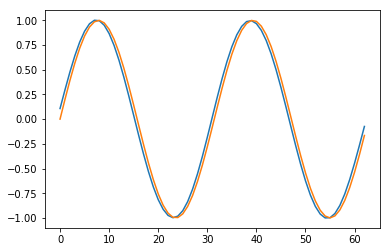

In [102]:
n_RBF = 10
a,b = trainRBF(n_RBF, pattern_train, sin_train, pattern_test, sin_test, var_RBF = 1)
plt.plot(b)
plt.plot(sin_test)

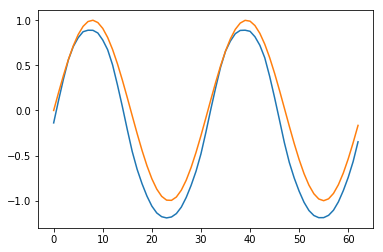

In [150]:
trainRBF(63, pattern_train, sin_train, pattern_test, sin_test, var_RBF = 0.15)#2*np.pi/n_RBF*1.5)

6.519973605731443e-07

In [149]:
2*np.pi/n_RBF*1.5

0.15201254775434483

In [145]:
len(pattern_train)

63

8.113640482015045e-06

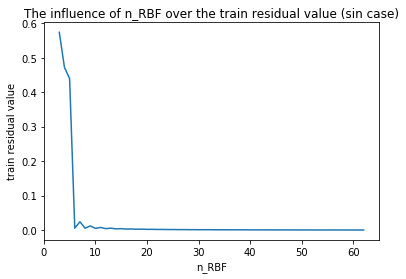

In [148]:
res_val = []
n1 = 3
n2 = len(pattern_train+1)
for n_RBF in range(n1, n2):
    res_val.append(trainRBF(n_RBF, pattern_train, sin_train, pattern_test, sin_test, var_RBF = 2*np.pi/n_RBF*1.5))
plt.plot(np.arange(n1, n2,1), res_val)
plt.xlabel("n_RBF")
plt.ylabel("train residual value")
plt.title("The influence of n_RBF over the train residual value (sin case)")
plt.plot()
min(res_val)
#np.arange(n1, n2,1)[res_val.index(min(res_val))]

### To choose variance 

In [284]:

k_var_array = np.arange(0.8, 2, 0.005)
print(len(var_array))
t0= time.time()
res_val = [np.mean([trainRBF(n_RBF, pattern_train, sin_train, pattern_test, sin_test, var_RBF = 2*np.pi/n_RBF*k_var_RBF)
                for n_RBF in range(10, len(pattern_train)+1)])
                for k_var_RBF in k_var_array]
print((time.time()-t0)/60)
res_val.index(min(res_val))

122
2.7481091459592184


166

In [289]:
def chooseRBFvar(x_train, y_train):
    var0 = 2*np.pi/n_RBF
    k_var_array = np.arange(0.2, 2, 0.005)
    t0 = time.time()
    res_val = [np.mean([trainRBF(n_RBF, x_train = x_train, y_train = y_train, x_test = x_train, y_test = y_train, var_RBF = 2*np.pi/n_RBF*k_var_RBF)
                for n_RBF in range(10, len(pattern_train)+1)])
                for k_var_RBF in k_var_array]
    return k_var_array[res_val.index(min(res_val))]

#k_var_sin = chooseRBFvar(pattern_train, sin_train)
#print("we choose var of sin function network RBF close to 2 * np.pi / n_RBF * ", k_var_sin )

#k_var_square = chooseRBFvar(pattern_train, square_train)
#print("we choose var of square function network RBF close to 2 * np.pi / n_RBF * ", k_var_square )



In [290]:
k_var_square = chooseRBFvar(pattern_train, square_train)
print("we choose var of square function network RBF close to 2 * np.pi / n_RBF * ", k_var_square )




we choose var of square function network RBF close to 2 * np.pi / n_RBF *  0.45500000000000024


### Finding n_RBF for each threshold

##### ALSO: Transforming output of sin RBF network to get square prediction

We just apply the same transformation we applied to get the square function target values initially (g(x) = box(x))

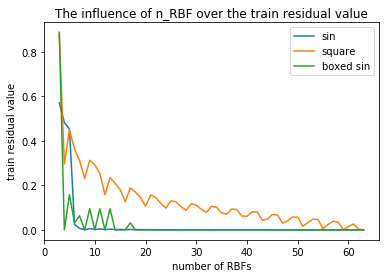

In [6]:
res_val_sin = []
n1 = 3
n2 = len(pattern_train)+1
k_var_sin = 1.63
for n_RBF in range(n1, n2):
    res_val_sin.append(trainRBF(n_RBF, pattern_train, sin_train, pattern_test, sin_test, var_RBF = 2*np.pi/n_RBF*k_var_sin))

res_val_square = []
k_var_square = 0.46
for n_RBF in range(n1, n2):
    res_val_square.append(trainRBF(n_RBF, pattern_train, square_train, pattern_test, square_test, var_RBF = 2*np.pi/n_RBF*k_var_square))

res_val_boxed_sin = []
k_var_boxed_sin = 1.63
for n_RBF in range(n1, n2):
    res_val_boxed_sin.append(trainRBF(n_RBF, pattern_train, square_train, pattern_test, square_test, var_RBF = 2*np.pi/n_RBF*k_var_square, apply_box_pred = True))



plt.plot(np.arange(n1, n2, 1), res_val_sin, label = "sin")
plt.plot(np.arange(n1, n2, 1), res_val_square, label = "square")
plt.plot(np.arange(n1, n2, 1), res_val_boxed_sin, label = "boxed sin")

plt.xlabel("number of RBFs")
plt.ylabel("train residual value")
plt.title("The influence of n_RBF over the train residual value")
plt.legend()
plt.plot()
plt.savefig("partI1_nRBF_residualvalue.png")

In [8]:
res_val_sin[:10]

[0.5720060248499081,
 0.4833234598434335,
 0.4539582872398865,
 0.024866765686573193,
 0.006695171490301755,
 0.0008118551080494328,
 0.005901231558434912,
 0.00205234794137655,
 0.004290178551056462,
 0.002023502823259172]

In [7]:
def find_thresholds(list):
    l, j, k = 0, 0, 0
    for i in range(len(list)) :
        if list[i] < 0.1 and l == 0:
            print("0.1 ->", i + n1)
            l = 1
        if list[i] < 0.01 and j == 0:
            print("0.01 ->", i + n1)
            j=1
        if list[i] < 0.001 and k == 0:
            print("0.001 ->", i + n1)
            k=1

print(" sin:")
print(find_thresholds(res_val_sin))
print("\n square:")
print(find_thresholds(res_val_square))
print("\n boxed sin:")
print(find_thresholds(res_val_boxed_sin))

 sin:
0.1 -> 6
0.01 -> 7
0.001 -> 8
None

 square:
0.1 -> 24
0.01 -> 55
0.001 -> 59
None

 boxed sin:
0.1 -> 4
0.01 -> 4
0.001 -> 4
None


However, square and boxed sin errors increase again (see plot above)

boxed sin

0.1 -> 6

0.01 -> 18

0.001 -> 18



square

0.1 -> 35

0.01 -> 63

0.001 -> 63

In [79]:
trainRBF(n_RBF, pattern_train, sin_train, pattern_test, square_test, var_RBF = 2*np.pi/n_RBF*k_var_square, apply_box_pred = True)[1]

IndexError: invalid index to scalar variable.

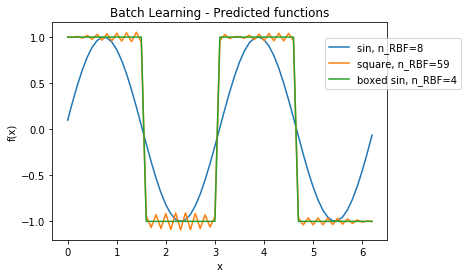

In [125]:
res_val_sin = []
n1 = 3
n2 = len(pattern_train)+1
k_var_sin = 1.63

sin_n_RBF = [8] 
for n_RBF in sin_n_RBF :
    plt.plot(pattern_test,
             trainRBF(n_RBF, pattern_train, sin_train, pattern_test, sin_test, var_RBF = 2*np.pi/n_RBF*k_var_sin)[1],
             label = "sin, n_RBF=%d"%(n_RBF))
    
square_n_RBF = [59] 
for n_RBF in square_n_RBF :
    plt.plot(pattern_test,
             trainRBF(n_RBF, pattern_train, square_train, pattern_test, square_test, var_RBF = 2*np.pi/n_RBF*k_var_sin)[1],
             label = "square, n_RBF=%d"%(n_RBF))

boxed_sin_n_RBF = [4] 
for n_RBF in boxed_sin_n_RBF :
    plt.plot(pattern_test,
             trainRBF(n_RBF, pattern_train, square_train, pattern_test, square_test, var_RBF = 2*np.pi/n_RBF*k_var_square, apply_box_pred = True)[1],
             label = "boxed sin, n_RBF=%d"%(n_RBF))


plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Batch Learning - Predicted functions")
plt.legend(bbox_to_anchor=(0.8, 0.95))
plt.plot()
plt.savefig("partI1_nRBF_predicted_functions.png")

In [ ]:
plt.plot(pattern_test,
         append(trainRBF(n_RBF, pattern_train, square_train, pattern_test, square_test, var_RBF = 2*np.pi/n_RBF*k_var_square)),
         label = )

res_val_boxed_sin = []
k_var_boxed_sin = 0.46
for n_RBF in range(n1, n2):
    res_val_boxed_sin.append(trainRBF(n_RBF, pattern_train, square_train, pattern_test, square_test, var_RBF = 2*np.pi/n_RBF*k_var_square, apply_box_pred = True))



plt.plot(np.arange(n1, n2, 1), res_val_sin, label = "sin")
plt.plot(np.arange(n1, n2, 1), res_val_square, label = "square")
plt.plot(np.arange(n1, n2, 1), res_val_boxed_sin, label = "boxed sin")



## 3.2 Regression with noise

### Add noise

In [9]:
mean = 0
std = np.sqrt(0.1)

pattern_test_noise = pattern_test #+ np.random.normal(mean, std, np.shape(pattern_test))
pattern_train_noise = pattern_train #+ np.random.normal(mean, std, np.shape(pattern_train))

sin_test_noise = sin_test + np.random.normal(mean, std, np.shape(sin_test))
sin_train_noise = sin_train + np.random.normal(mean, std, np.shape(sin_train))

square_test_noise = square_test + np.random.normal(mean, std, np.shape(square_test))
square_train_noise = square_train + np.random.normal(mean, std, np.shape(square_train))

### Implementation of on-line learning with delta rule

In [10]:
def deltaRBF(x_train,
             y_train,
             x_test, 
             y_test, 
             n_RBF = 20, 
             var_RBF =1, 
             return_training = False, 
             eta=1, 
             n_epochs = 10,
             mu = placeRBFs(n_RBF, 0, 2*np.pi)) : 

    k=1
    # computing phi matrix
    
    sigma = var_RBF * np.ones(n_RBF)
    train_errors = []
    w = np.ones(n_RBF).reshape((n_RBF, 1))
    
    for m in range(n_epochs):
        random_indices = random.sample(list(np.arange(0,len(x_train), 1)), len(x_train))
        for k in random_indices :
            phi_k = np.array([[gaussianRBF(x_train[k], i, mu, sigma)] for i in range(n_RBF)])

            delta_w = eta * (y_train[k] - np.array(transpose(phi_k)).dot(w))[0][0]* phi_k
            w = w + delta_w
            
            if return_training == True :
                phi_train = np.array([[gaussianRBF(x_train[j], i, mu, sigma) for i in range(n_RBF)] for j in range(len(x_train))])
                y_pred_train = phi_train.dot(w)
                train_errors.append(np.mean(abs(y_pred_train - y_train)))

    phi_test = np.array([[gaussianRBF(x_test[j], i, mu, sigma) for i in range(n_RBF)] for j in range(len(x_train))])
    y_pred = phi_test.dot(w)

    if return_training == True :
        return np.mean(abs(y_pred - y_train)), train_errors
    
    else:
        return np.mean(abs(y_pred - y_train))


In [11]:
 
a,b = deltaRBF(x_train = pattern_train_noise,
         y_train = sin_train_noise,
         x_test = pattern_train_noise,
         y_test = sin_train_noise,
         var_RBF = 1,
           return_training = True,
              eta = 0.001, 
              n_epochs = 20)


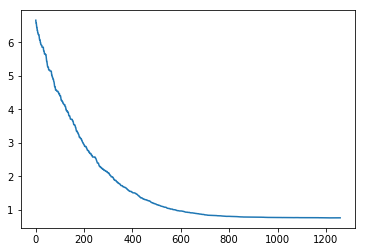

In [12]:
plt.plot(b)

### Effect of number of RBFs and weights

In [157]:
n_RBF

62

In [16]:
t0=time.time()
n_RBF = 10
var_RBF_array = np.arange(0.00001, 3, 0.1)
scores_delta = [avgdeltaRBF(n_avg = 10,
                            var_RBF = var_RBF,
                            n_RBF = n_RBF,
                            x_train = pattern_train,
                            y_train = sin_train,
                            x_test = pattern_train,
                            y_test = sin_train)
                 for var_RBF in var_RBF_array ]

scores_delta_noise = [avgdeltaRBF(n_avg = 10,
                                    var_RBF = var_RBF,
                                    n_RBF = n_RBF,
                                    x_train = pattern_train_noise,
                                    y_train = sin_train_noise,
                                    x_test = pattern_train_noise,
                                    y_test = sin_train_noise)
         for var_RBF in var_RBF_array ]

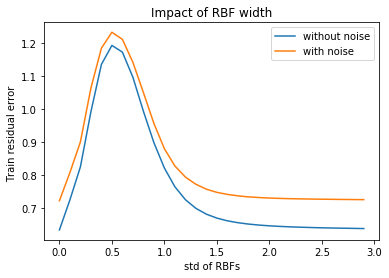

In [17]:
plt.plot(np.arange(0.00001, 3, 0.1), scores_delta, label = "without noise")
plt.plot(np.arange(0.00001, 3, 0.1), scores_delta_noise, label = "with noise")
plt.legend()
plt.title("Impact of RBF width")

plt.xlabel("std of RBFs")
plt.ylabel("Train residual error ")
plt.savefig("partI2_RBFwidth_impact.png")


### On test set

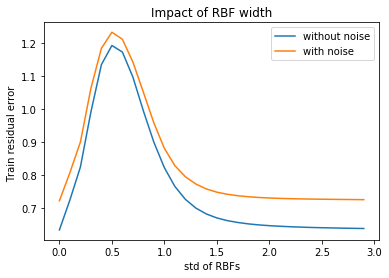

In [18]:
t0=time.time()
n_RBF = 10
var_RBF_array = np.arange(0.00001, 3, 0.1)
scores_delta = [avgdeltaRBF(n_avg = 10,
                            var_RBF = var_RBF,
                            n_RBF = n_RBF,
                            x_train = pattern_train,
                            y_train = sin_train,
                            x_test = pattern_test,
                            y_test = sin_test)
                 for var_RBF in var_RBF_array ]

scores_delta_noise = [avgdeltaRBF(n_avg = 10,
                                    var_RBF = var_RBF,
                                    n_RBF = n_RBF,
                                    x_train = pattern_train_noise,
                                    y_train = sin_train_noise,
                                    x_test = pattern_test_noise,
                                    y_test = sin_test_noise)
         for var_RBF in var_RBF_array ]
plt.plot(np.arange(0.00001, 3, 0.1), scores_delta, label = "without noise")
plt.plot(np.arange(0.00001, 3, 0.1), scores_delta_noise, label = "with noise")
plt.legend()
plt.title("Impact of RBF width")

plt.xlabel("std of RBFs")
plt.ylabel("Test residual error ")
plt.savefig("partI2_RBFwidth_impact.png")



In [19]:
def avgdeltaRBF(n_avg = 10, var_RBF= 1, n_RBF = 10,
                x_train = pattern_train_noise,
                y_train = sin_train_noise,
                x_test = pattern_train_noise,
                y_test = sin_train_noise,
                eta = 0.001,
                mu = placeRBFs(n_RBF, 0, 2*np.pi),
               return_std = False) :
    scores = []
    for i in range(n_avg):
        a  = deltaRBF(x_train = x_train,
             y_train = y_train,
             x_test = x_test,
             y_test = y_test,
            n_RBF = n_RBF,
             var_RBF = var_RBF,
               return_training = False,
                  eta = eta, 
                  n_epochs = 20,
                       mu=mu)
        scores.append(a)
    if return_std==False:
        return np.mean(scores)
    else :
        return np.mean(scores), np.std(scores)
    

In [27]:
np.arange(0.1, 1, 0.2)

array([0.1, 0.3, 0.5, 0.7, 0.9])

In [42]:
t0=time.time()
var_RBF_array = [0.5, 1, 1.5, 2, 2.5][::-1]
n_RBF_array = np.arange(10, 61, 10)
scores_delta = [[avgdeltaRBF(10, var_RBF, n_RBF)
         for var_RBF in var_RBF_array ]
           for n_RBF in n_RBF_array]
scores_ls = [[trainRBF(n_RBF, pattern_train, square_train, pattern_test, square_test, var_RBF = var_RBF)#2*np.pi/n_RBF*k_var_square)
         for var_RBF in var_RBF_array ]
          for n_RBF in n_RBF_array]
score_delta
print((time.time()-t0)/60)

0.915144419670105


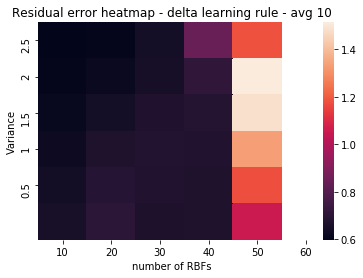

In [43]:
ax = sns.heatmap(scores_delta,
            yticklabels = [round(elem, 2) for elem in var_RBF_array],
            xticklabels = n_RBF_array)
ax.set_title("Residual error heatmap - delta learning rule - avg 10")
plt.xlabel('number of RBFs')
plt.ylabel('Variance')
plt.plot()
plt.show()

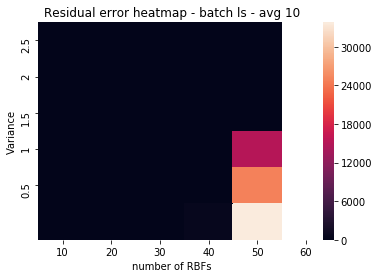

In [46]:
ax = sns.heatmap(scores_ls,
            yticklabels = [round(elem, 2) for elem in var_RBF_array],
            xticklabels = n_RBF_array)
ax.set_title("Residual error heatmap - batch ls - avg 10")
plt.xlabel('number of RBFs')
plt.ylabel('Variance')
plt.plot()
plt.show()

### Rate of convergence ; learning rate


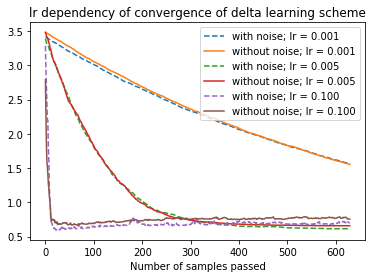

In [77]:
eta_array = [0.001, 0.005, 0.1]
for eta in eta_array : 
    score, train_plot_noise = deltaRBF(var_RBF= 1, n_RBF = 10,
                x_train = pattern_train_noise,
                 y_train = sin_train_noise,
                 x_test = pattern_train_noise,
                 y_test = sin_train_noise,
                return_training = True,
                eta = eta
               ) 
    score, train_plot = deltaRBF( var_RBF= 1, n_RBF = 10,
                x_train = pattern_train,
                 y_train = sin_train,
                 x_test = pattern_train,
                 y_test = sin_train,
                return_training = True,
                eta = eta
               ) 
    plt.plot(train_plot_noise, '--', label = "with noise; lr = %.3f"%(eta))
    plt.plot(train_plot, label = "without noise; lr = %.3f"%(eta))
    
plt.title("lr dependency of convergence of delta learning scheme")
plt.xlabel("Number of samples passed")  
plt.legend()
plt.show("Training score")



### Positioning of RBFs

In [33]:
n_RBF=10
n_avg_train = 10
n_avg_random = 10
scores_noise = []
scores = []
score = avgdeltaRBF(n_avg=n_avg_train,
                    var_RBF = 1,
                    n_RBF = n_RBF,
                    x_train = pattern_train_noise,
                    y_train = sin_train_noise,
                    x_test = pattern_train_noise,
                    y_test = sin_train_noise,
                    eta = 0.005
                    ) 
scores_noise.append(score)

score = avgdeltaRBF(n_avg = n_avg_train,
                    var_RBF = 1,
                    n_RBF = n_RBF,
                    x_train = pattern_train,
                    y_train = sin_train,
                    x_test = pattern_train,
                    y_test = sin_train,
                    eta = 0.005
                    )
scores.append(score)

print("EQUIDISTANT PLACEMENT RBFs")
print("noise : ", np.mean(scores_noise))
print("no noise :", np.mean(scores))



EQUIDISTANT PLACEMENT RBFs
noise :  0.7127305318057255
no noise : 0.6560896074225928


In [35]:
n_RBF = 10
n_avg_train = 10
n_avg_random = 100
scores_noise = []
scores = []
for k in range(n_avg_random):
    mu = random.sample(list(np.arange(0, 2 * np.pi, 0.001)), n_RBF )
    
    score = avgdeltaRBF(n_avg=n_avg_train,
                        var_RBF = 1,
                        n_RBF = n_RBF,
                        x_train = pattern_train_noise,
                        y_train = sin_train_noise,
                        x_test = pattern_train_noise,
                        y_test = sin_train_noise,
                        eta = 0.005,
                        mu = mu
                        ) 
    scores_noise.append(score)

    score = avgdeltaRBF(n_avg = n_avg_train,
                        var_RBF = 1,
                        n_RBF = n_RBF,
                        x_train = pattern_train,
                        y_train = sin_train,
                        x_test = pattern_train,
                        y_test = sin_train,
                        eta = 0.005,
                        mu = mu
                        )
    scores.append(score)

print("RANDOM RBF PLACEMENT")
print("noise : ", np.mean(scores_noise))
print("no noise :", np.mean(scores))

RANDOM RBF PLACEMENT
noise :  0.7168835540750894
no noise : 0.6638389143810244


In [63]:
n_RBF = 1
avgdeltaRBF(n_avg = 1,
            var_RBF = 2*np.pi/n_RBF*1.5 ,
            n_RBF = n_RBF,
            x_train = pattern_train,
            y_train = sin_train,
            x_test = pattern_train,
            y_test = sin_train,
            eta = 0.005,
            mu =random.sample(list(np.arange(0, 2 * np.pi, 0.001)), n_RBF )
            )

0.6348467191179148

In [54]:
2*np.pi/n_RBF*1.5

0.9424777960769379